In [1]:
# let's extract features that can help us make a better model 

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 
plt.style.use( 'bmh' ) 

In [3]:
import pyrosetta 
import rosetta 
import pandas 
import numpy as np 
from sklearn import linear_model, cross_validation, metrics, feature_selection, preprocessing 

In [4]:
targets = pandas.read_csv( '/Users/alex/Documents/bagel-thermal/data_set/targets.csv', index_col=0 ) 
targets = targets[['target_kcat']].dropna().drop( 'BglB' ) 
targets.shape

(75, 1)

In [5]:
targets.sample( 5 ) 

,target_kcat
mutant,
F415A,-2.944483
N220H,-0.854578
N404A,-2.342423
L171A,-0.037609
S298E,-0.036534


In [6]:
pyrosetta.init( '-beta -extra_res_fa reference_files/pNPG.params' )

Found rosetta database at: /usr/local/bin/anaconda3/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:7862c3a14bb5e8d6b2a4c3e0a497795bc06e9e4b 2016-12-13 14:39:52 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [7]:
fmt = dict( zip( 'ANDRCQEGHILKMPFSTWYV', [
    'ALA','ASN','ASP','ARG','CYS','GLN','GLU',
    'GLY','HIS','ILE','LEU','LYS','MET','PRO','PHE','SER',
    'THR','TRP','TYR','VAL' ] ) )

In [8]:
def generate_big_features( mutant_name ):
    
    target = int(mutant_name[1:-1])
    new_res = fmt[mutant_name[-1]]

    p = pyrosetta.pose_from_file( 'reference_files/bglb.pdb' ) 
    s = pyrosetta.create_score_function( 'beta_cst' ) 
    s(p)
    score_types = s.get_nonzero_weighted_scoretypes()
    
    # run protocol 
    mut = rosetta.protocols.simple_moves.MutateResidue( target, new_res ) 
    mut.apply( p ) 
    
    # score, and then collect scores
    s(p)
    f_names = []
    f_vals = []
    energies = p.energies()
    for i in range( 1, p.total_residue() + 1 ):
        res_energies = energies.residue_total_energies( i )
        for st in score_types:
            nm = rosetta.core.scoring.name_from_score_type( st ) 
            f_names.append( nm ) 
            f_vals.append( res_energies.get( st ) ) 
            
    return f_names, f_vals 

In [9]:
df = pandas.DataFrame( columns=range( 14272 ) ) 
for m in targets.index:
    names, vals = generate_big_features( m ) 
    df.loc[ m ] = vals 

In [10]:
df.shape

(75, 14272)

In [11]:
#for tar in [ 'kcat', 'km', 'kcatkm', 'tm' ]:

T = targets.join( df ) 
T.shape

(75, 14273)

In [12]:
X = T.ix[:,1:]
y = T.ix[:,0].ravel()

In [13]:
X.shape

(75, 14272)

In [14]:
y.shape

(75,)

In [20]:
var = feature_selection.VarianceThreshold( 0.5 ) 
scl = preprocessing.RobustScaler()
trans = scl.fit_transform(var.fit_transform( X ))
trans.shape

(75, 93)

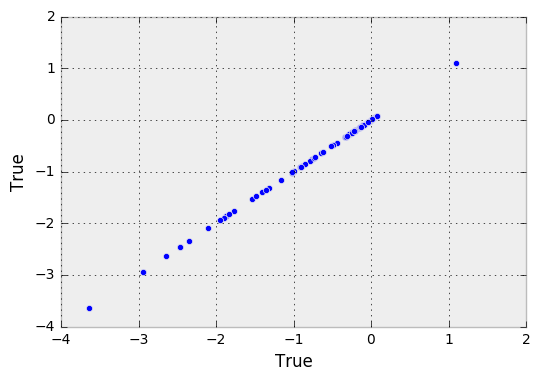

In [25]:
plt.scatter( y, y )
plt.xlabel( 'True' ) 
plt.ylabel( 'True' ) 

In [44]:
clf = linear_model.ElasticNetCV( max_iter=1e9, selection='random', cv=3 )
preds = cross_validation.cross_val_predict( clf, trans, y, cv=10 )  

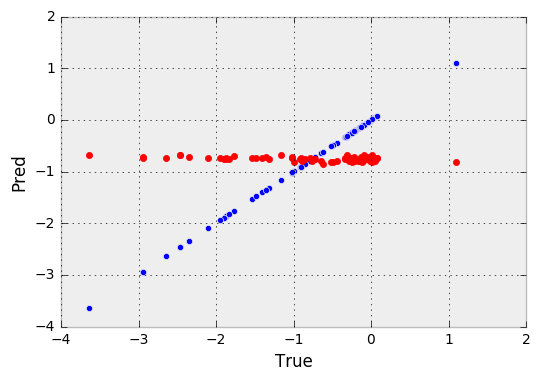

In [47]:
plt.scatter( y, y )
plt.scatter( y, preds, color='red' ) 
plt.xlabel( 'True' ) 
plt.ylabel( 'Pred' ) 